In [7]:
import warnings

warnings.filterwarnings('ignore')

from time import time
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
from numpy.linalg import LinAlgError

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

DATA_PATH = Path('data')
STORE = DATA_PATH / 'assets.h5'

critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349}, 1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}

trace0_cv = critical_values[0][.95]  # critical value for 0 cointegration relationship
trace1_cv = critical_values[1][.95]  # critical value for 1 cointegration relationship

In [8]:
def remove_correlated_assets(df, cutoff=.99):
    corr = df.corr().stack()
    corr = corr[corr < 1]
    to_check = corr[corr.abs() > cutoff].index
    keep, drop = set(), set()
    for s1, s2 in to_check:
        if s1 not in keep:
            if s2 not in keep:
                keep.add(s1)
                drop.add(s2)
            else:
                drop.add(s1)
        else:
            keep.discard(s2)
            drop.add(s2)
    return df.drop(drop, axis=1)


def check_stationarity(df):
    results = []
    for ticker, prices in df.items():
        results.append([ticker, adfuller(prices, regression='ct')[1]])
    return pd.DataFrame(results, columns=['ticker', 'adf']).sort_values('adf')

def remove_stationary_assets(df, pval=.05):
    test_result = check_stationarity(df)
    stationary = test_result.loc[test_result.adf <= pval, 'ticker'].tolist()
    return df.drop(stationary, axis=1).sort_index()

In [9]:
def select_assets(asset_class='stocks', n=500, start=2010, end=2019):
    idx = pd.IndexSlice
    with pd.HDFStore(STORE) as store:
        df = (pd.concat([store[f'stooq/us/nasdaq/{asset_class}/prices'],
                         store[f'stooq/us/nyse/{asset_class}/prices']])
              # stooq download can have duplicate assets
              .loc[lambda df: ~df.index.duplicated()].sort_index()
              .loc[idx[:, f'{start}':f'{end}'], :].assign(dv=lambda df: df.close.mul(df.volume)))

    # select n assets with the highest average trading volume
    # we are taking a shortcut to simplify; should select
    # based on historical only, e.g. yearly rolling avg
    most_traded = (df.groupby(level='ticker').dv.mean().nlargest(n=n).index)

    df = (df.loc[idx[most_traded, :], 'close'].unstack('ticker')
          .ffill(limit=5)  # fill up to five values
          .dropna(axis=1))  # remove assets with any missing values

    df = remove_correlated_assets(df)
    return remove_stationary_assets(df).sort_index()

In [10]:
with pd.HDFStore(STORE) as store:
    print(store.info())
    # print(store['/us_equities/stocks '])

<class 'pandas.io.pytables.HDFStore'>
File path: data\assets.h5
/engineered_features                        frame        (shape->[358914,33])                                                                
/quandl/wiki/prices                         frame        (shape->[15389314,12])                                                              
/quandl/wiki/stocks                         frame        (shape->[1,2])                                                                      
/sp500/fred                                 frame        (shape->[2608,1])                                                                   
/sp500/stocks                               frame        (shape->[503,7])                                                                    
/sp500/stooq                                frame        (shape->[18517,5])                                                                  
/stooq/jp/tse/stocks/prices                 frame_table  (typ->appendable_multi,nrow

In [11]:
for asset_class, n in [('etfs', 500), ('stocks', 250)]:
    df = select_assets(asset_class=asset_class, n=n)
    df.to_hdf('data/data.h5', f'{asset_class}/close')

In [12]:
def get_ticker_dict():
    with pd.HDFStore(STORE) as store:
        return (pd.concat([store['stooq/us/nyse/stocks/tickers'], store['stooq/us/nyse/etfs/tickers'],
            store['stooq/us/nasdaq/etfs/tickers'], store['stooq/us/nasdaq/stocks/tickers']
        ]).drop_duplicates().set_index('ticker').squeeze().to_dict())

names = get_ticker_dict()

In [13]:
names

{'A.US': ' AGILENT TECHNOLOGIES',
 'AA.US': 'ALCOA',
 'AAC-U.US': ' ARES ACQUISITION',
 'AAC-WS.US': ' ARES ACQUISITION',
 'AAC.US': ' ARES ACQUISITION',
 'AACT-U.US': ' ARES ACQUISITION II',
 'AAIC.US': 'ARLINGTON ASSET INVESTMENT',
 'AAIC_B.US': ' Arlington Asset Investment Cor',
 'AAIC_C.US': ' Arlington Asset Investment Cor',
 'AAIN.US': 'Arlington Asset Investment Cor',
 'AAM_A.US': ' Apollo Asset Management',
 'AAM_B.US': ' Apollo Asset Management',
 'AAN.US': " AARON'S",
 'AAP.US': ' ADVANCE AUTO PARTS',
 'AAT.US': ' AMERICAN ASSETS TRUST',
 'AB.US': 'ALLIANCEBERNSTEIN HOLDING',
 'ABB.US': ' ABB',
 'ABBV.US': 'ABBVIE',
 'ABC.US': ' AMERISOURCEBERGEN',
 'ABEV.US': 'AMBEV',
 'ABG.US': ' ASBURY AUTOMOTIVE GROUP',
 'ABM.US': ' ABM INDUSTRIES',
 'ABR.US': ' ARBOR REALTY TRUST',
 'ABR_D.US': ' Arbor Realty Trust',
 'ABR_E.US': ' Arbor Realty Trust',
 'ABR_F.US': ' Arbor Realty Trust',
 'ABT.US': ' ABBOTT LABORATORIES',
 'AC.US': 'ASSOCIATED CAPITAL GROUP',
 'ACA.US': ' ARCOSA',
 'ACCO

In [14]:
stocks = pd.read_hdf('data/data.h5', 'stocks/close')
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 172 entries, AAPL.US to FSLR.US
dtypes: float64(172)
memory usage: 3.3 MB


In [15]:
etfs = pd.read_hdf('data/data.h5', 'etfs/close')
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 132 entries, SPY.US to EWN.US
dtypes: float64(132)
memory usage: 2.6 MB


In [16]:
tickers = {k: v for k, v in names.items() if k in etfs.columns.union(stocks.columns)}
pd.Series(tickers).to_hdf('data/data.h5', 'tickers')

In [17]:
corr = pd.DataFrame(index=stocks.columns)
for etf, data in etfs.items():
    corr[etf] = stocks.corrwith(data)

corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, AAPL.US to FSLR.US
Columns: 132 entries, SPY.US to EWN.US
dtypes: float64(132)
memory usage: 182.8+ KB


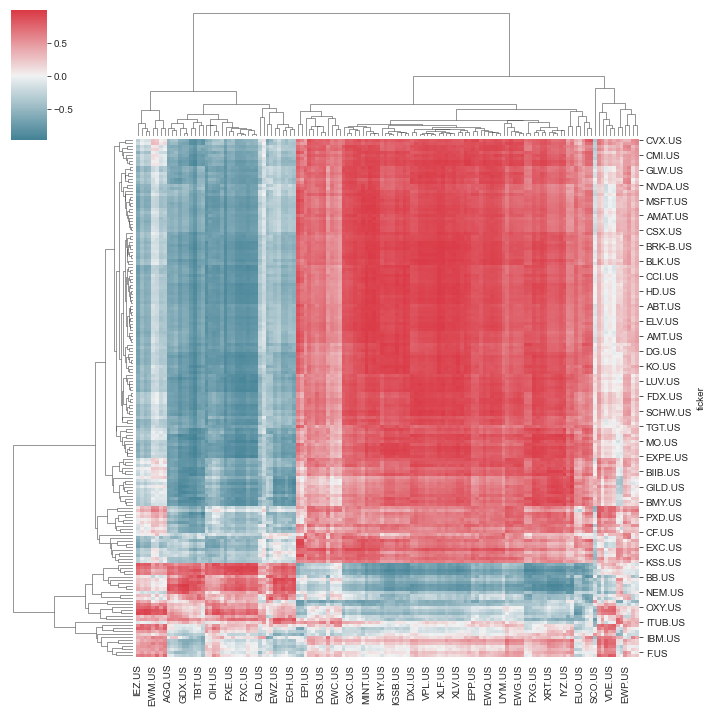

In [18]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.clustermap(corr, cmap=cmap, center=0)

In [19]:
stocks.shape, etfs.shape

((2516, 172), (2516, 132))

In [20]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 172 entries, AAPL.US to FSLR.US
dtypes: float64(172)
memory usage: 3.3 MB


In [21]:
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 132 entries, SPY.US to EWN.US
dtypes: float64(132)
memory usage: 2.6 MB


In [22]:
security = etfs['AAXJ.US'].loc['2010': '2013']
candidates = stocks.loc['2010': '2013']

security = security.div(security.iloc[0])
candidates = candidates.div(candidates.iloc[0])
spreads = candidates.sub(security, axis=0)
n, m = spreads.shape
X = np.ones(shape=(n, 2))
X[:, 1] = np.arange(1, n+1)

In [24]:
%%timeit
np.linalg.inv(X.T @ X) @ X.T @ spreads # Heuristics

616 µs ± 162 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [25]:
%%timeit
spreads.std()

847 µs ± 29.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [26]:
%%timeit
candidates.corrwith(security)

51.8 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%%timeit
for candidate, prices in candidates.items():
    df = pd.DataFrame({'s1': security, 's2': prices})
    var = VAR(df.values) # Vector AR
    lags = var.select_order()
    k_ar_diff = lags.selected_orders['aic']
    coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
    coint(security, prices, trend='c')[:2]
    coint(prices, security, trend='c')[:2]

17.5 s ± 846 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
def compute_pair_metrics(security, candidates):
    security = security.div(security.iloc[0])
    ticker = security.name
    candidates = candidates.div(candidates.iloc[0])
    spreads = candidates.sub(security, axis=0)
    n, m = spreads.shape
    X = np.ones(shape=(n, 2))
    X[:, 1] = np.arange(1, n + 1)

    # compute drift
    drift = ((np.linalg.inv(X.T @ X) @ X.T @ spreads).iloc[1]
             .to_frame('drift'))

    # compute volatility
    vol = spreads.std().to_frame('vol')

    # return correlation
    corr_ret = (candidates.pct_change().corrwith(security.pct_change()).to_frame('corr_ret'))

    # normalized price series correlation
    corr = candidates.corrwith(security).to_frame('corr')
    metrics = drift.join(vol).join(corr).join(corr_ret).assign(n=n)

    tests = []
    # run cointegration tests
    for candidate, prices in tqdm(candidates.items()):
        df = pd.DataFrame({'s1': security, 's2': prices})
        var = VAR(df.values)
        lags = var.select_order() # select VAR order
        k_ar_diff = lags.selected_orders['aic']
        # Johansen Test with constant Term and estd. lag order
        cj0 = coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
        # Engle-Granger Tests
        # coint reject case: cointegration exists
        # if almost same line for both, t-stat=-inf & p-value = 0
        t1, p1 = coint(security, prices, trend='c')[:2]
        t2, p2 = coint(prices, security, trend='c')[:2]
        tests.append([ticker, candidate, t1, p1, t2, p2, k_ar_diff, *cj0.lr1])
    columns = ['s1', 's2', 't1', 'p1', 't2', 'p2', 'k_ar_diff', 'trace0', 'trace1']
    tests = pd.DataFrame(tests, columns=columns).set_index('s2')
    return metrics.join(tests)
spreads = []
start = 2010
stop = 2019
etf_candidates = etfs.loc[str(start): str(stop), :]
stock_candidates = stocks.loc[str(start): str(stop), :]
s = time()
for i, (etf_ticker, etf_prices) in enumerate(etf_candidates.items(), 1):
    df = compute_pair_metrics(etf_prices, stock_candidates)
    spreads.append(df.set_index('s1', append=True))
    if i % 10 == 0:
        print(f'\n{i:>3} {time() - s:.1f}\n')
        s = time()
names = get_ticker_dict()
spreads = pd.concat(spreads)
spreads.index.names = ['s2', 's1']
spreads = spreads.swaplevel()
spreads['name1'] = spreads.index.get_level_values('s1').map(names)
spreads['name2'] = spreads.index.get_level_values('s2').map(names)
spreads['t'] = spreads[['t1', 't2']].min(axis=1)
spreads['p'] = spreads[['p1', 'p2']].min(axis=1)

172it [00:52,  3.30it/s]
172it [00:50,  3.44it/s]
172it [00:49,  3.46it/s]
172it [00:53,  3.22it/s]
172it [00:49,  3.47it/s]
172it [00:48,  3.52it/s]
172it [00:49,  3.50it/s]
172it [00:49,  3.48it/s]
172it [00:51,  3.34it/s]
172it [00:50,  3.41it/s]



 10 506.0


172it [00:49,  3.44it/s]
172it [00:49,  3.49it/s]
172it [00:52,  3.26it/s]
172it [00:50,  3.40it/s]
172it [00:53,  3.24it/s]
172it [00:53,  3.22it/s]
172it [00:54,  3.14it/s]
172it [00:51,  3.33it/s]
172it [00:53,  3.19it/s]
172it [00:48,  3.56it/s]



 20 519.0


172it [00:47,  3.61it/s]
172it [00:49,  3.49it/s]
172it [00:50,  3.38it/s]
172it [00:46,  3.67it/s]
172it [00:54,  3.14it/s]
172it [00:51,  3.32it/s]
172it [00:53,  3.21it/s]
172it [00:53,  3.22it/s]
172it [00:54,  3.15it/s]
172it [00:50,  3.42it/s]



 30 514.7


172it [00:48,  3.53it/s]
172it [00:47,  3.61it/s]
172it [00:47,  3.61it/s]
172it [00:49,  3.45it/s]
172it [00:47,  3.61it/s]
172it [00:46,  3.66it/s]
172it [00:47,  3.59it/s]
172it [00:47,  3.63it/s]
172it [00:47,  3.63it/s]
172it [00:47,  3.59it/s]



 40 480.0


172it [00:48,  3.55it/s]
172it [00:46,  3.73it/s]
172it [00:46,  3.66it/s]
172it [00:49,  3.49it/s]
172it [00:46,  3.71it/s]
172it [00:47,  3.64it/s]
172it [00:46,  3.67it/s]
172it [00:46,  3.69it/s]
172it [00:47,  3.65it/s]
172it [00:48,  3.53it/s]



 50 475.1


172it [00:47,  3.64it/s]
172it [00:49,  3.50it/s]
172it [00:47,  3.64it/s]
172it [00:47,  3.59it/s]
172it [00:56,  3.07it/s]
172it [00:55,  3.08it/s]
172it [00:52,  3.25it/s]
172it [00:49,  3.45it/s]
172it [00:50,  3.40it/s]
172it [00:53,  3.20it/s]



 60 511.6


172it [00:50,  3.37it/s]
172it [00:49,  3.45it/s]
172it [00:50,  3.38it/s]
172it [00:52,  3.25it/s]
172it [00:53,  3.24it/s]
172it [00:58,  2.94it/s]
172it [00:58,  2.95it/s]
172it [00:56,  3.06it/s]
172it [00:55,  3.09it/s]
172it [00:56,  3.03it/s]



 70 544.7


172it [00:56,  3.04it/s]
172it [00:56,  3.06it/s]
172it [00:55,  3.12it/s]
172it [00:53,  3.20it/s]
172it [00:56,  3.03it/s]
172it [00:51,  3.37it/s]
172it [00:50,  3.38it/s]
172it [00:51,  3.35it/s]
172it [00:50,  3.41it/s]
172it [00:49,  3.46it/s]



 80 533.3


172it [00:51,  3.31it/s]
172it [00:50,  3.41it/s]
172it [00:52,  3.28it/s]
172it [00:51,  3.36it/s]
172it [00:53,  3.19it/s]
172it [00:52,  3.26it/s]
172it [00:54,  3.18it/s]
172it [00:54,  3.14it/s]
172it [00:52,  3.26it/s]
172it [00:53,  3.23it/s]



 90 528.7


172it [00:52,  3.31it/s]
172it [00:52,  3.27it/s]
172it [00:53,  3.20it/s]
172it [00:54,  3.14it/s]
172it [00:54,  3.14it/s]
172it [00:53,  3.23it/s]
172it [00:53,  3.19it/s]
172it [00:53,  3.21it/s]
172it [00:54,  3.17it/s]
172it [00:52,  3.25it/s]



100 537.3


172it [00:53,  3.23it/s]
172it [00:52,  3.30it/s]
172it [00:52,  3.30it/s]
172it [00:54,  3.18it/s]
172it [00:53,  3.21it/s]
172it [00:51,  3.32it/s]
172it [00:52,  3.27it/s]
172it [00:55,  3.10it/s]
172it [00:56,  3.05it/s]
172it [00:55,  3.08it/s]



110 538.4


172it [00:54,  3.13it/s]
172it [00:54,  3.16it/s]
172it [00:53,  3.22it/s]
172it [00:52,  3.26it/s]
172it [00:54,  3.14it/s]
172it [00:55,  3.09it/s]
172it [00:55,  3.08it/s]
172it [00:54,  3.17it/s]
172it [00:52,  3.29it/s]
172it [00:52,  3.26it/s]



120 542.5


172it [00:56,  3.02it/s]
172it [00:53,  3.21it/s]
172it [00:56,  3.04it/s]
172it [00:50,  3.38it/s]
172it [00:50,  3.43it/s]
172it [00:52,  3.30it/s]
172it [00:49,  3.45it/s]
172it [00:52,  3.29it/s]
172it [00:48,  3.57it/s]
172it [00:52,  3.26it/s]



130 524.5


172it [00:51,  3.36it/s]
172it [00:49,  3.49it/s]


In [29]:
spreads['trace_sig'] = ((spreads.trace0 > trace0_cv) & (spreads.trace1 > trace1_cv)).astype(int)
spreads['eg_sig'] = (spreads.p < .05).astype(int)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 22704 entries, ('SPY.US', 'AAPL.US') to ('EWN.US', 'FSLR.US')
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   drift      22704 non-null  float64
 1   vol        22704 non-null  float64
 2   corr       22704 non-null  float64
 3   corr_ret   22704 non-null  float64
 4   n          22704 non-null  int64  
 5   t1         22704 non-null  float64
 6   p1         22704 non-null  float64
 7   t2         22704 non-null  float64
 8   p2         22704 non-null  float64
 9   k_ar_diff  22704 non-null  int64  
 10  trace0     22704 non-null  float64
 11  trace1     22704 non-null  float64
 12  name1      22704 non-null  object 
 13  name2      22704 non-null  object 
 14  t          22704 non-null  float64
 15  p          22704 non-null  float64
 16  trace_sig  22704 non-null  int32  
 17  eg_sig     22704 non-null  int32  
 18  coint      22704 non-null  int32  
dtypes: float64

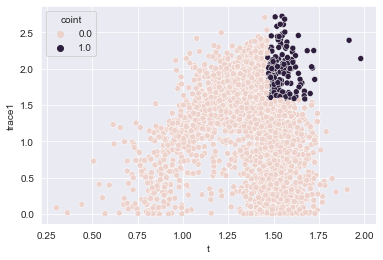

In [30]:
pd.crosstab(spreads.eg_sig, spreads.trace_sig)
spreads['coint'] = (spreads.trace_sig & spreads.eg_sig).astype(int)
spreads.info()
spreads = spreads.reset_index()
sns.scatterplot(x=np.log1p(spreads.t.abs()), y=np.log1p(spreads.trace1),
                hue='coint', data=spreads[spreads.trace0>trace0_cv]);
spreads.to_hdf('heuristics.h5', 'spreads')
spreads = pd.read_hdf('heuristics.h5', 'spreads')

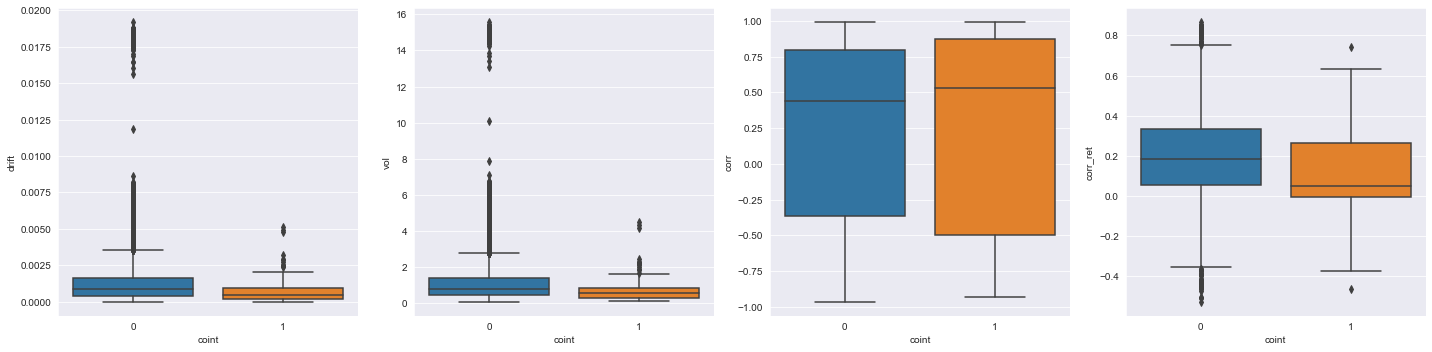

In [31]:
# Evaluate Heuristics
spreads.drift = spreads.drift.abs()
pd.crosstab(spreads.eg_sig, spreads.trace_sig)
pd.set_option('display.float_format', lambda x: f'{x:.2%}')
pd.crosstab(spreads.eg_sig, spreads.trace_sig, normalize=True)
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
for i, heuristic in enumerate(['drift', 'vol', 'corr', 'corr_ret']):
    sns.boxplot(x='coint', y=heuristic, data=spreads, ax=axes[i])
fig.tight_layout();

In [32]:
spreads.groupby(spreads.coint)['drift', 'vol', 'corr'].describe().stack(level=0).swaplevel().sort_index()
spreads.coint.value_counts()

0    22536
1      168
Name: coint, dtype: int64

,count,mean,std,min,25%,50%,75%,max
coint,,,,,,,,
0,2253600.00%,50.00%,0.00%,50.00%,50.00%,50.00%,50.00%,50.00%
1,16800.00%,50.00%,0.00%,50.00%,50.00%,50.00%,50.00%,50.00%


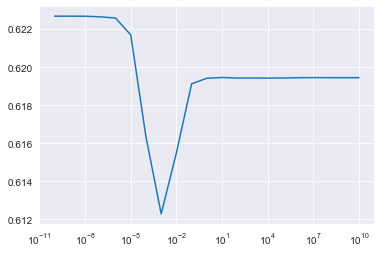

In [33]:
# Logistic Regression
y = spreads.coint
X = spreads[['drift', 'vol', 'corr', 'corr_ret']]
# X = spreads[['drift', 'vol']]
kf = StratifiedKFold(n_splits=5, shuffle=True)
log_reg = LogisticRegressionCV(Cs=np.logspace(-10, 10, 21), class_weight='balanced', scoring='roc_auc')
log_reg.fit(X=X, y=y)
Cs = log_reg.Cs_
scores = pd.DataFrame(log_reg.scores_[True], columns=Cs).mean()
scores.plot(logx=True);
f'C:{np.log10(scores.idxmax()):.2f}, AUC: {scores.max():.2%}'
log_reg.coef_
y_pred = log_reg.predict_proba(X)[:, 1]
confusion_matrix(y_true=spreads.coint, y_pred=(y_pred>.5))
spreads.assign(y_pred=log_reg.predict_proba(X)[:, 1]).groupby(spreads.coint).y_pred.describe()

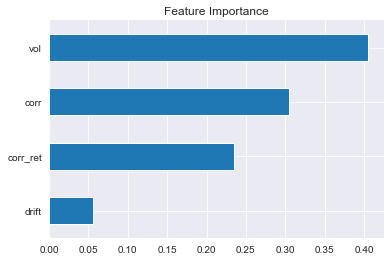

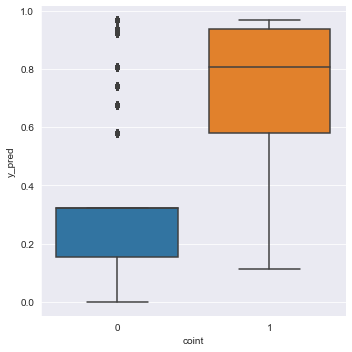

In [34]:
# Decision Tree Classifier
model = DecisionTreeClassifier(class_weight='balanced')
decision_tree = GridSearchCV(model, param_grid={'max_depth': list(range(1, 10))}, cv=5, scoring='roc_auc')
decision_tree.fit(X=X, y=y)
f'{decision_tree.best_score_:.2%}, Depth: {decision_tree.best_params_["max_depth"]}'
pd.Series(data=decision_tree.best_estimator_.feature_importances_, index=X.columns).sort_values().plot.barh(title='Feature Importance')
sns.despine()
spreads.assign(y_pred=decision_tree.predict_proba(X)[:, 1]).groupby(spreads.coint).y_pred.describe()
sns.catplot(x='coint', y='y_pred', data=spreads.assign(y_pred=decision_tree.predict_proba(X)[:, 1]), kind='box');